In [39]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D

In [ ]:
import pandas as pd

# Attempt to read the file, handling potential errors
try:
    movie_reviews = pd.read_csv('/content/IMDB Dataset.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Inspect the problematic row and surrounding rows
    problematic_row_index = 35632
    with open('/content/IMDB Dataset.csv', 'r') as file:
        lines = file.readlines()
        for i in range(problematic_row_index - 2, problematic_row_index + 3):
            if 0 <= i < len(lines):
                print(f"Line {i+1}: {lines[i]}")

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews.isnull().any()

,0
review,False
sentiment,False


In [ ]:
movie_reviews.shape

(50000, 2)

<Axes: xlabel='sentiment', ylabel='count'>

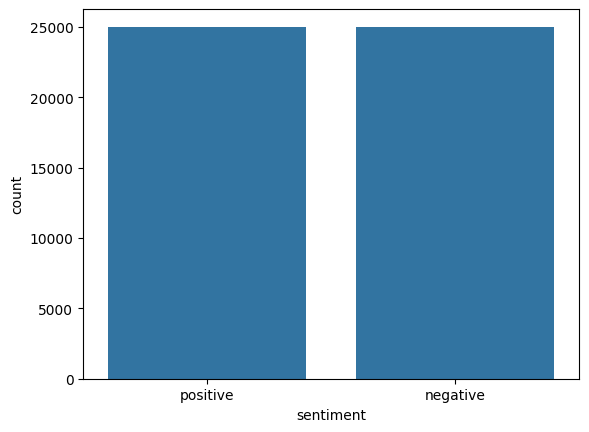

In [16]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [17]:
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [18]:
target_tag = re.compile(r'<[^>]+>')

def remove_tags(text):
    return target_tag.sub('', text)

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
def preprocess_text(sen):
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

In [21]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [22]:
X[5]

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slow awakening happening world roof believable startling dozen thumbs movie '

In [23]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
word_tokenizer = text.Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [26]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [27]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [28]:
!kaggle datasets download -d sawarn69/glove6b100dtxt

Dataset URL: https://www.kaggle.com/datasets/sawarn69/glove6b100dtxt
License(s): unknown
 95% 125M/131M [00:01<00:00, 119MB/s]
100% 131M/131M [00:01<00:00, 101MB/s]


In [29]:
!unzip glove6b100dtxt.zip

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [30]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [31]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [32]:
embedding_matrix.shape

(92394, 100)

In [33]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [36]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.6660 - loss: 0.6086 - val_acc: 0.7570 - val_loss: 0.5068
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8030 - loss: 0.4433 - val_acc: 0.7651 - val_loss: 0.4992
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8278 - loss: 0.3974 - val_acc: 0.7639 - val_loss: 0.5045
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.8401 - loss: 0.3754 - val_acc: 0.7591 - val_loss: 0.5098
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.8470 - loss: 0.3617 - val_acc: 0.7580 - val_loss: 0.5174
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.8441 - loss: 0.3585 - val_acc: 0.7577 - val_loss: 0.5290
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.8556 - loss: 0.3416 - val_acc: 0.7548 - val_loss: 0.5441
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.8588 - loss: 0.3305 - val_acc: 0.7540 - val_loss: 0.5530
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - a

In [37]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.7422 - loss: 0.6068


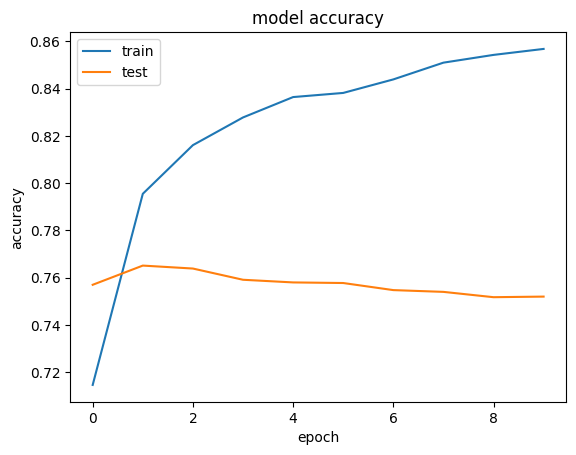

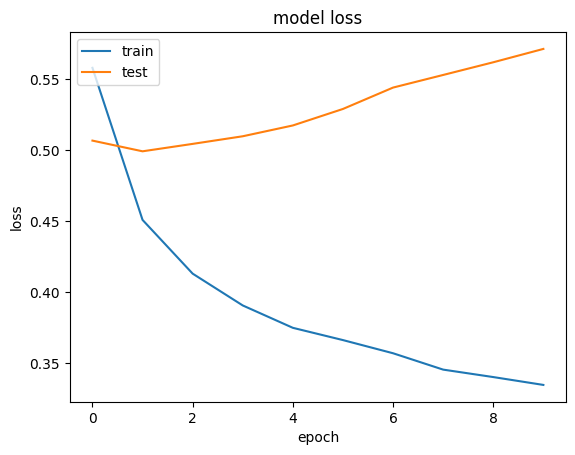

In [38]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [42]:
snn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (128, 100, 100)             │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (128, 10000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (128, 1)                    │          10,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,269,405 (35.36 MB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 20,004 (78.14 KB)

In [40]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [41]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [43]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - acc: 0.7279 - loss: 0.5204 - val_acc: 0.8415 - val_loss: 0.3665
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - acc: 0.8634 - loss: 0.3261 - val_acc: 0.8482 - val_loss: 0.3402
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - acc: 0.9042 - loss: 0.2511 - val_acc: 0.8468 - val_loss: 0.3466
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - acc: 0.9314 - loss: 0.2003 - val_acc: 0.8505 - val_loss: 0.3431
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - acc: 0.9601 - loss: 0.1497 - val_acc: 0.8549 - val_loss: 0.3421
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - acc: 0.9755 - loss: 0.1099 - val_acc: 0.8528 - val_loss: 0.3552
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - acc: 0.9869 - loss: 0.0793 - val_acc: 0.8541 - val_loss: 0.3687
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - acc: 0.9945 - loss: 0.0568 - val_acc: 0.8479 - val_loss: 0.3955
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [44]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8436 - loss: 0.4335


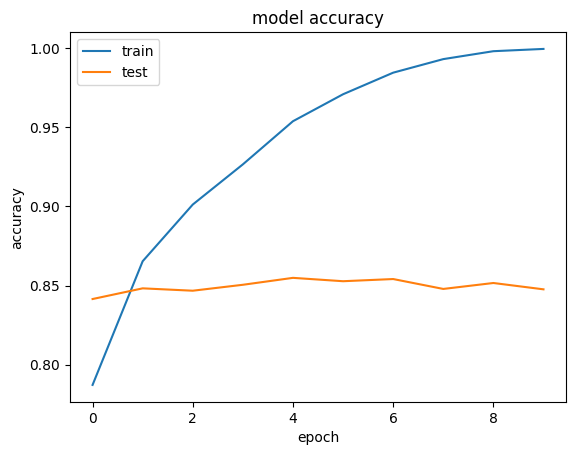

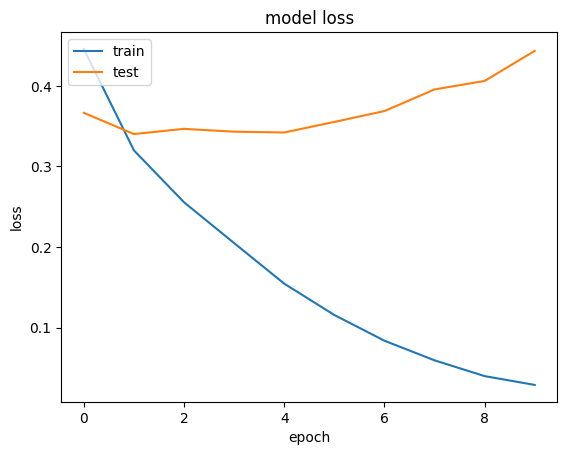

In [45]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [48]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (64, 100, 100)              │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (64, 96, 128)               │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (64, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (64, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,432,173 (35.98 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 128,516 (502.02 KB)

In [46]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [47]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [49]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 388ms/step - acc: 0.6678 - loss: 0.5962 - val_acc: 0.8094 - val_loss: 0.4270
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 364ms/step - acc: 0.8013 - loss: 0.4405 - val_acc: 0.7979 - val_loss: 0.4399
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 358ms/step - acc: 0.8273 - loss: 0.4001 - val_acc: 0.8503 - val_loss: 0.3564
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 364ms/step - acc: 0.8489 - loss: 0.3514 - val_acc: 0.8594 - val_loss: 0.3256
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 154s 412ms/step - acc: 0.8636 - loss: 0.3256 - val_acc: 0.8683 - val_loss: 0.3150
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 426ms/step - acc: 0.8773 - loss: 0.2995 - val_acc: 0.8511 - val_loss: 0.3345


In [50]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - acc: 0.8506 - loss: 0.3380


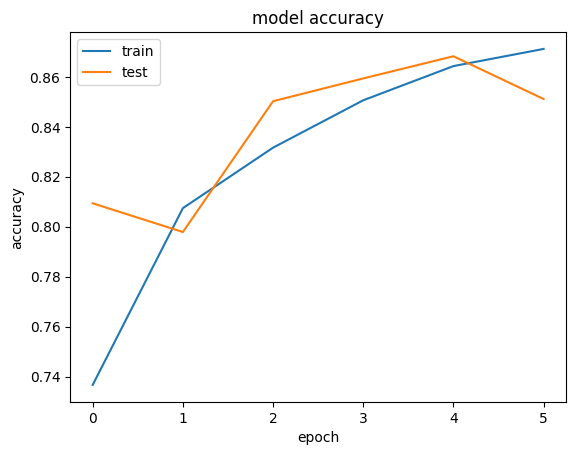

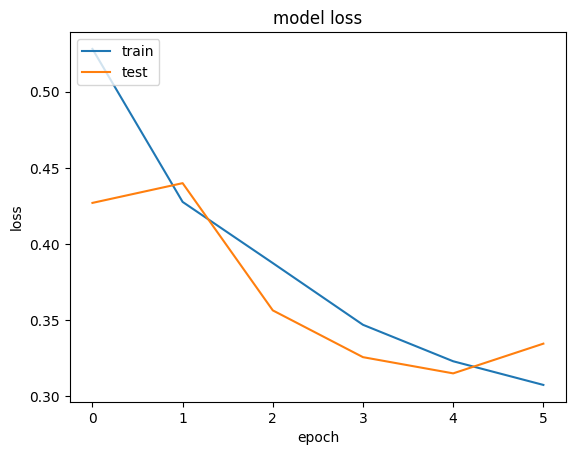

In [51]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (128, 100, 100)             │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (128, 128)                  │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (128, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,591,533 (36.59 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 234,756 (917.02 KB)

In [57]:
review = 'Best film ever This is the first sequel where I am not able to decide between part 1 and part 2 but still i would say Stree Part 1 is slightly better than this in terms of  comedyRajkumar again what a superb actor he is but I have no idea why he did plastic surgery on face looking bit weird but acting is as usual superb Rajkumar Rao is once again in top form, delivering his signature performance with strong support from Aparshakti Khurana and Abhishek Banerjee The first movie was a massive success and the sequel created an enormous buzz before its release special mention to Sachin Jigar music and Tammanah Bhatia dance too good '

In [58]:
review = preprocess_text(review)

In [59]:
unseen_tokenized = word_tokenizer.texts_to_sequences(review)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [60]:
y_pred = lstm_model.predict(unseen_padded)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


In [63]:
rating =  np.round(y_pred*10,1)

In [66]:
print(np.mean(rating))

6.400706


In [67]:
lstm_model.save('lstm_movie_review.keras')